# **Chuẩn bị dữ liệu**

In [17]:
#Chạy hết các câu lệnh sau rồi Restart kernel

# !pip install torch==2.3.1 torchtext==0.18.0 torchdata==0.7.1 portalocker
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# !pip install nltk

## Import các thư viện cần thiết

In [18]:
import torchtext
import torch
from torchtext.datasets import Multi30k, multi30k
from torch.utils.data import Dataset

## Load dataset

### Tìm và tải các datasets

Vì bị lỗi file test do server của multi30k đã sập, lấy file test và giải nén bị lỗi.

**Cách giải quyết:**
 - Vẫn dùng hàm Multi30k() -> Tải các file .gz từ Github về -> Giải nén ra thành file Text -> Đặt vào thư mục .data. Khi đó hàm Multi30k() sẽ thấy dữ liệu và sẵn sàng để hoạt động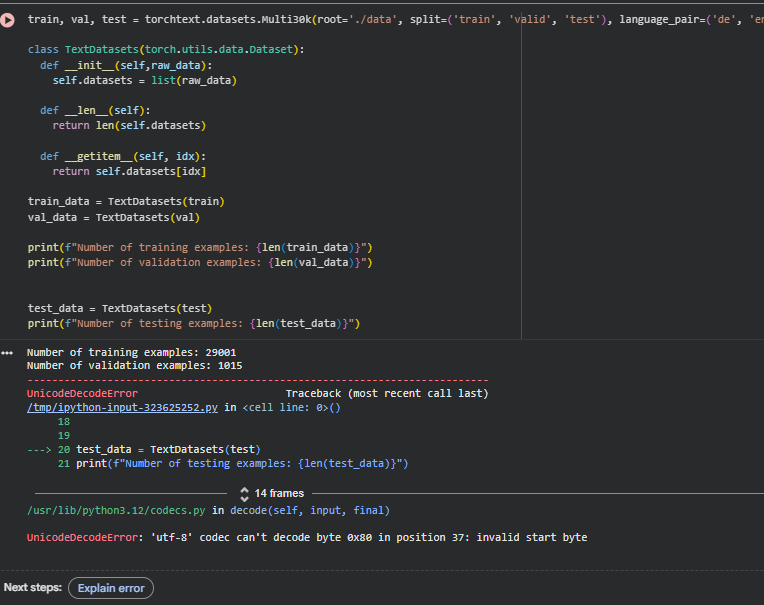

In [27]:
import os
import requests
import gzip #dùng để giải nén và nén thư mục
import shutil #dùng để copy file
#Xóa .data cũ và thay bằng folder mới
data_root = './data' #đường dẫn đến folder data trong google colab
#if os.path.exists(data_root):
#  !rm -rf {data_root} #Xóa đi folder data chứa data lỗi

os.makedirs(f"{data_root}/Multi30k",exist_ok=True) #Tạo lại folder data

#Link github để tải dataset
BASE_URL = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw"
files_map = {
    "train.de.gz": "train.de",
    "train.en.gz": "train.en",
    "val.de.gz":   "val.de",
    "val.en.gz":   "val.en",
    #dùng tập test 2018
    "test_2018_flickr.de.gz": "test2018.de",
    "test_2018_flickr.en.gz": "test2018.en"
}

missing_file = False
for github_name, name in files_map.items():
  save_path = f"{data_root}/Multi30k/{name}" #Đường dẫn cho các file dataset
  if not os.path.exists(save_path): #Nếu folder có files thì không tải lại
    missing_file = True #set cờ để chạy
    response = requests.get(f"{BASE_URL}/{github_name}")
    if response.status_code == 200: #nếu status code == 200 thì request được
      content = gzip.decompress(response.content) #giải nén file dataset
      with open(save_path, "wb") as f: #mở file để ghi
        f.write(content)
    else:
      print(f"Lỗi yêu cầu đến {github_name}")

#copy lại các file test để backup
if not os.path.exists(f'{data_root}/Multi30k/test.de'):
  shutil.copy(f"{data_root}/Multi30k/test2018.de", f"{data_root}/Multi30k/test.de")
  shutil.copy(f"{data_root}/Multi30k/test2018.en", f"{data_root}/Multi30k/test.en")

### Đọc dữ liệu thành Text

In [28]:
from torch.utils.data import Dataset
class ManualTextDataset(Dataset):
    def __init__(self, src, target):
        self.data = []

        # Kiểm tra file có tồn tại không
        if not os.path.exists(src) or not os.path.exists(target):
            raise FileNotFoundError(f"Missing {src} file or {target} file")

        print(f'Đọc {src} và {target}')
        # Mở 2 file cùng lúc và ghép dòng tương ứng
        with open(src, 'r', encoding='utf-8') as f_src, \
             open(target, 'r', encoding='utf-8') as f_trg:

            for line_src, line_trg in zip(f_src, f_trg):
                # Chỉ lấy nếu cả 2 dòng đều có chữ
                if line_src.strip() and line_trg.strip():
                    self.data.append((line_src.strip(), line_trg.strip()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [29]:
print("Tạo Dataset: ")

train_datasets = ManualTextDataset(f"{data_root}/Multi30k/train.en", f"{data_root}/Multi30k/train.de")
valid_datasets = ManualTextDataset(f"{data_root}/Multi30k/val.en",   f"{data_root}/Multi30k/val.de")
test_datasets  = ManualTextDataset(f"{data_root}/Multi30k/test.en",  f"{data_root}/Multi30k/test.de")

print(f"Train size: {len(train_datasets)}")
print(f"Valid size: {len(valid_datasets)}")
print(f"Test size:  {len(test_datasets)}")

# Kiểm tra thử 1 mẫu
print(f"\nMẫu dữ liệu đầu tiên:\n {train_datasets[0]}")

Tạo Dataset: 
Đọc ./data/Multi30k/train.en và ./data/Multi30k/train.de
Đọc ./data/Multi30k/val.en và ./data/Multi30k/val.de
Đọc ./data/Multi30k/test.en và ./data/Multi30k/test.de
Train size: 29000
Valid size: 1014
Test size:  1071

Mẫu dữ liệu đầu tiên:
 ('Two young, White males are outside near many bushes.', 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.')


## Triển khai Tokenizer

In [22]:
from torchtext.data.utils import get_tokenizer
en_tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
de_tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')

## Xây dựng từ điển cho mô hình

- Dùng build_vocab_iterator

- Thêm token đặc biệt: unk, pad, sos , eos

- Limit: 10k từ phổ biến nhất mỗi ngôn ngữ

In [23]:
from torchtext.vocab import build_vocab_from_iterator
#Hàm hỗ trợ tách chữ
def yield_tokens(data,tokenizer,dataset_index):
  for sample in data: #Lấy từng cặp câu trong data ra
    yield tokenizer(sample[dataset_index]) #Chọn ngôn ngữ và tách chữ (0 là Anh, 1 là Đức)

special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>'] #token đặc biệt
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

#Source là Anh (index 0):
vocab_src = build_vocab_from_iterator(yield_tokens(train_datasets, en_tokenizer, 0),
                                      min_freq=2, specials=special_symbols, max_tokens=10000)

vocab_src.set_default_index(UNK_IDX)
#Set UNK_IDX là index mặc định. Index trả về khi không tìm thấy token.
#Nếu không set thì sẽ chạy ra lỗi RuntimeError khi mà không tìm thấy token trong Vocab

# Target là Đức (index 1)
vocab_target = build_vocab_from_iterator(yield_tokens(train_datasets, de_tokenizer, 1),
    min_freq=2, specials=special_symbols, max_tokens=10000)

vocab_target.set_default_index(UNK_IDX)

print(f"Vocab Source (Anh): {len(vocab_src)}")
print(f"Vocab Target (Đức): {len(vocab_target)}")

Vocab Source (Anh): 6191
Vocab Target (Đức): 8014


In [24]:
print(vocab_src.get_stoi())
print(vocab_target.get_stoi())

{'pitch': 1533, 'pouring': 1021, 'wires': 1869, 'fruit': 529, 'point': 2242, 'Some': 431, '.': 5, 'woods': 454, 'little': 61, 'newspapers': 1832, '<unk>': 0, 'pushes': 958, 'fires': 5358, 'sing': 1233, 'street': 40, 'moped': 1524, 'in': 7, 'customers': 1004, 'taping': 6056, 'mood': 5655, 'attire': 468, 'kicked': 2847, 'probably': 2895, 'soccer': 129, 'daily': 2546, 'kimono': 5552, 'cottage': 5224, '<eos>': 3, 'softly': 5974, 'An': 53, 'splash': 3307, 'laundry': 1015, '<pad>': 1, 'crane': 1502, 'smoke': 1413, 'cowboy': 464, 'storage': 3835, 'flags': 562, 'Elmo': 2143, 'polish': 3714, 'balding': 1489, 'openings': 5696, 'guiding': 5437, 'A': 6, 'doll': 1801, 'garbage': 1139, 'workers': 266, 'winter': 461, 'taste': 3861, 'seems': 1231, 'outdoors': 354, 'her': 45, 'activity': 2013, 'hose': 857, 'turbulent': 6114, 'group': 39, 'gentleman': 579, 'bald': 714, 'underway': 4684, 'a': 4, 'scaffolds': 5869, 'outside': 57, 'drivers': 3535, 'readying': 3739, 'jeans': 177, 'black': 26, 'to': 18, 'jun

## Padding

In [25]:
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence

def Text2ListNum(text,tokenizer,vocab):
  #Tách từ
  tokens = tokenizer(text.strip())
  #format lại thêm SOS đầu, EOS cuối, và chuyển thành số ID lấy từ vocab ở trên
  return [SOS_IDX] + [vocab[token] for token in tokens] + [EOS_IDX]

def collate_fn(batch):
  """
  Input: List tuples [(src_1,target_1),(src_2, target_2),...]
  Output: padded Sourced, padded target, source lengths
  """
  #Khởi tạo mảng src và target
  src_batch, target_batch = [],[]
  #Vòng lặp chạy qua các câu trong batch
  for src_sample, target_sample in batch:

    src_tensor = torch.tensor(Text2ListNum(src_sample, en_tokenizer, vocab_src),
                              dtype=torch.long)
    target_tensor = torch.tensor(Text2ListNum(target_sample, de_tokenizer, vocab_target),
                              dtype=torch.long)

    src_batch.append(src_tensor)
    target_batch.append(target_tensor)

  #ghép lại thành cặp để đồng bộ sort không lệch
  combined = list(zip(src_batch, target_batch))
  #giảm dần theo chiều dài câu source
  combined.sort(key=lambda x: len(x[0]),reverse=True)
  #tách ra lại
  src_batch, target_batch = zip(*combined)

  src_len = torch.tensor([len(x) for x in src_batch])
  target_len = torch.tensor([len(x) for x in target_batch])

  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX,batch_first=True)
  target_batch = pad_sequence(target_batch, padding_value=PAD_IDX,batch_first=True)

  return src_batch, target_batch, src_len, target_len

## DataLoader

In [26]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128

train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE,
                          shuffle=True,collate_fn=collate_fn)
valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE,
                          shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE,
                          shuffle=False,collate_fn=collate_fn)

print("--- BẮT ĐẦU DUYỆT DATA ---")

# enumerate giúp đếm số thứ tự batch (i)
for i, (src, trg, src_len, tar_len) in enumerate(train_loader):

    print(f"\nBatch thứ {i}:")
    print(f" - Kích thước Src: {src.shape}")
    print(f" - Kích thước Trg: {trg.shape}")
    print(f" - Kích thước Src_len: {src_len.shape}")

    if i == 5:
        break

--- BẮT ĐẦU DUYỆT DATA ---

Batch thứ 0:
 - Kích thước Src: torch.Size([128, 28])
 - Kích thước Trg: torch.Size([128, 30])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 1:
 - Kích thước Src: torch.Size([128, 26])
 - Kích thước Trg: torch.Size([128, 28])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 2:
 - Kích thước Src: torch.Size([128, 29])
 - Kích thước Trg: torch.Size([128, 27])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 3:
 - Kích thước Src: torch.Size([128, 36])
 - Kích thước Trg: torch.Size([128, 27])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 4:
 - Kích thước Src: torch.Size([128, 29])
 - Kích thước Trg: torch.Size([128, 28])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 5:
 - Kích thước Src: torch.Size([128, 33])
 - Kích thước Trg: torch.Size([128, 34])
 - Kích thước Src_len: torch.Size([128])


# Triển khai và huấn luyện mô hình

## Xây dựng mô hình

In [14]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMModel(nn.Module):
    def __init__(self, src_size, target_size, embed_dim, hidden_dim, lstm_layers=2, drop_out=0.3, t_ratio = 0.5):
        super().__init__()
        self.encoder_embedding = nn.Embedding(src_size, embedding_dim= embed_dim)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, lstm_layers, batch_first=True, dropout= drop_out)

        self.decoder_embedding = nn.Embedding(target_size, embedding_dim= embed_dim)
        self.decoder_lstm = nn.LSTM(embed_dim, hidden_dim, lstm_layers, batch_first=True, dropout= drop_out)
        self.fc = nn.Linear(hidden_dim, target_size)

    def forward(self, src, tgt, src_lengths, tgt_lengths, teacher_forcing_ratio=0.5):

      # ===== ENCODER =====
      embedded_src = self.encoder_embedding(src)
      packed_src = pack_padded_sequence(
          embedded_src,
          src_lengths,
          batch_first=True,
          enforce_sorted=True
      )
      _, (h, c) = self.encoder_lstm(packed_src)


      # ===== DECODER =====
      batch_size = tgt.size(0)
      max_len    = tgt.size(1)
      vocab_size = self.fc.out_features

      # to store decoder outputs
      outputs = torch.zeros(batch_size, max_len, vocab_size, device=src.device)

      # first input to decoder = <BOS>
      input_token = tgt[:, 0]      # [batch]

      for t in range(1, max_len):

          # embed the input token
          input_embedded = self.decoder_embedding(input_token).unsqueeze(1)

          # decode one step
          output, (h, c) = self.decoder_lstm(input_embedded, (h, c))

          # predict token distribution
          logits = self.fc(output.squeeze(1))
          outputs[:, t, :] = logits

          # choose next input
          teacher_force = (torch.rand(1) < teacher_forcing_ratio)

          if teacher_force:
              # use ground-truth token
              input_token = tgt[:, t]
          else:
              # use model prediction
              input_token = logits.argmax(dim=-1)

      return outputs




## Hàm đánh giá

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def compute_loss(logits, targets):
    # logits: [batch, seq_len, vocab_size]
    # targets: [batch, seq_len]

    logits = logits.reshape(-1, logits.size(-1))    # [B*T, vocab]
    targets = targets.reshape(-1)                   # [B*T]

    loss = criterion(logits, targets)
    return loss


In [31]:
def compute_accuracy(logits, targets):
    # logits: [batch, seq_len, vocab_size]
    pred = logits.argmax(dim=-1)  # [batch, seq_len]

    correct = (pred == targets).float().sum()
    total = targets.numel()

    acc = correct / total
    return acc.item()


In [32]:
import math
def compute_perplexity(loss):
    return math.exp(loss)


In [33]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# def compute_bleu(logits, targets):
#     return sentence_bleu([targets], logits)

def compute_bleu(logits, targets):
    """
    Tính BLEU score cho một batch.
    logits: [batch_size, seq_len, vocab_size]
    targets: [batch_size, seq_len]
    """
    # Chuyển Logits (xác suất) thành Index (số thứ tự từ)
    # Lấy ra từ có xác suất cao nhất tại mỗi vị trí
    preds = logits.argmax(dim=-1).tolist() 
    targets = targets.tolist()

    score = 0
    batch_size = len(targets)
    
    # Dùng hàm làm mượt để tránh bị điểm 0 khi câu quá ngắn
    smoothie = SmoothingFunction().method1 

    # Duyệt qua từng cặp câu trong batch
    for pred, target in zip(preds, targets):
        # Lọc bỏ các token đặc biệt (SOS, EOS, PAD)
        # Chỉ giữ lại nội dung chính để tính điểm cho công bằng
        pred_clean = [p for p in pred if p not in [SOS_IDX, EOS_IDX, PAD_IDX]]
        target_clean = [t for t in target if t not in [SOS_IDX, EOS_IDX, PAD_IDX]]

        # ==== Tính BLEU ==== 
        # Nếu model chưa học được gì và dự đoán rỗng -> 0 điểm
        if len(pred_clean) == 0:
            score += 0
        else:
            # NLTK yêu cầu references phải là list lồng nhau: [[ref]]
            score += sentence_bleu([target_clean], pred_clean, smoothing_function=smoothie)

    # Trả về trung bình cộng của cả batch
    return score / batch_size


## Định tham số mô hình

In [34]:
hidden_size = 512
embedding_dim = 256
lstm_layer = 2
drop_out = 0.3
teacher_forcing_ratio = 0.5

## Khời tạo mô hình

In [35]:
import torch
from torch.optim import Adam

model = LSTMModel(len(vocab_src), len(vocab_target), embedding_dim, hidden_size, lstm_layer)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

## Định tham số huấn luyện

In [36]:
EPOCHS = 20
PATIENCE = 3
best_val_loss = float("inf")
patience_counter = 0

## Định tham số lưu trữ và đánh giá

In [37]:
Loss = []
Bleu = []

## Huấn luyện

In [32]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    total_bleu = 0.0
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # TRAIN LOOP
    for i,(batch_x, batch_y, x_lengths, y_lengths) in enumerate(train_loader):

        logits = model(batch_x, batch_y, x_lengths, y_lengths)

        loss = compute_loss(logits, batch_y)
        acc = compute_accuracy(logits, batch_y)
        ppx = compute_perplexity(loss)
        bleu = compute_bleu(logits, batch_y)

        if i % 50 == 0:
            print(f"  - Batch {i+1}: loss={loss.item():.4f} | acc={acc:.4f} | ppx={ppx:.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bleu += bleu

        del logits, loss
        torch.cuda.empty_cache()

    train_loss = total_loss / len(train_loader)
    train_bleu = total_bleu / len(train_loader)

    # VALIDATION LOOP
    model.eval()
    val_loss = 0.0
    val_bleu = 0.0

    with torch.no_grad():
        for vx, vy, vx_lens, vy_lens in valid_loader:
            v_logits = model(vx, vy, vx_lens, vy_lens)
            v_loss = compute_loss(v_logits, vy)
            v_bleu = compute_bleu(v_logits, vy)

            val_loss += v_loss.item()
            val_bleu += v_bleu

    val_loss /= len(valid_loader)
    val_bleu /= len(valid_loader)

    Loss.append(train_loss)
    Loss.append(val_loss)
    Bleu.append(train_bleu)
    Bleu.append(val_bleu)

    # EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), "best_model.pt") -> Chỉ save các trọng số của mô hình
        # |
        # V
        # Save tất cả dữ liệu: trọng số, loss, bleu. (Optinal): Lưu cả vocab
        print(f"Save checkpoint at epoch{epoch+1}")
        checkpoint_data = {
            'epoch' : epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': Loss,  # Lưu Loss (cả train và val)
            'bleu_history': Bleu,  # Lưu Bleu (cả train và val)
            'vocab_src': vocab_src,
            'vocab_target': vocab_target
        }
        torch.save(checkpoint_data, "best_model.pt")
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered!")
        break


Epoch 1/20
  - Batch 1: loss=8.9685 | acc=0.0003 | ppx=7852.0183


KeyboardInterrupt: 

# Load lại checkpoint (Chạy hết tất cả trừ Outline: Huấn luyện)

In [38]:
# --- LOAD CHECKPOINT & VẼ GRAPH ---
checkpoint_path = "best_model.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists(checkpoint_path):
    print(f"\n>>> Đang load dữ liệu từ {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # 1. Load Model (để dịch)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 2. Load Lịch sử (để vẽ)
    history_loss = checkpoint['loss_history']
    history_bleu = checkpoint['bleu_history']
    saved_epoch = checkpoint['epoch']
    
    print(f"Load thành công! Model dừng tại epoch {saved_epoch}.")
    
else:
    print("Chưa có file checkpoint để load.")
# Tách list tổng thành train/val (Vị trí chẵn là Train, lẻ là Val)
train_loss_list = history_loss[0::2]
val_loss_list   = history_loss[1::2]
    
train_bleu_list = history_bleu[0::2]
val_bleu_list   = history_bleu[1::2]
    
epochs_range = range(1, len(train_loss_list) + 1)



>>> Đang load dữ liệu từ best_model.pt...
Load thành công! Model dừng tại epoch 11.


# Chỉ số Bleu của từng Epoches

In [40]:
if len(train_bleu_list) > 0:
        print(f"\n{'='*15} LỊCH SỬ HUẤN LUYỆN CHI TIẾT {'='*15}")
        print(f"{'Epoch':<6} | {'Train Loss':<12} | {'Val Loss':<10} | {'Train BLEU':<12} | {'Val BLEU':<10}")
        print("-" * 65)

        for i in range(len(train_bleu_list)):
            print(f"{i+1:<6} | {train_loss_list[i]:<12.4f} | {val_loss_list[i]:<10.4f} | {train_bleu_list[i]:<12.4f} | {val_bleu_list[i]:<10.4f}")
        
        print("-" * 65)
        n = len(train_bleu_list)
        avg_train_loss = sum(train_loss_list) / n
        avg_val_loss   = sum(val_loss_list) / n
        avg_train_bleu = sum(train_bleu_list) / n
        avg_val_bleu   = sum(val_bleu_list) / n
        print(f"{'AVG':<6} | {avg_train_loss:<12.4f} | {avg_val_loss:<10.4f} | {avg_train_bleu:<12.4f} | {avg_val_bleu:<10.4f}")
        print("Ghi chú: Điểm BLEU thang 0-1. Nhân với 100 để ra phần trăm.")
else:
    print("Không tìm thấy file checkpoint.")


=============== LỊCH SỬ HUẤN LUYỆN CHI TIẾT ===============
Epoch  | Train Loss   | Val Loss   | Train BLEU   | Val BLEU  
-----------------------------------------------------------------
1      | 2.8452       | 2.5406     | 0.0289       | 0.0391    
2      | 2.3627       | 2.2168     | 0.0454       | 0.0600    
3      | 2.1370       | 2.0723     | 0.0689       | 0.0833    
4      | 1.9760       | 1.9233     | 0.0888       | 0.1077    
5      | 1.8378       | 1.8588     | 0.1104       | 0.1291    
6      | 1.7261       | 1.7494     | 0.1300       | 0.1393    
7      | 1.6154       | 1.7109     | 0.1505       | 0.1526    
8      | 1.5341       | 1.6995     | 0.1699       | 0.1641    
9      | 1.4420       | 1.6344     | 0.1912       | 0.1740    
10     | 1.3658       | 1.6684     | 0.2088       | 0.1840    
11     | 1.2858       | 1.6202     | 0.2337       | 0.1863    
-----------------------------------------------------------------
AVG    | 1.8298       | 1.8813     | 0.1297       |

# Biểu đồ Bleu và Loss

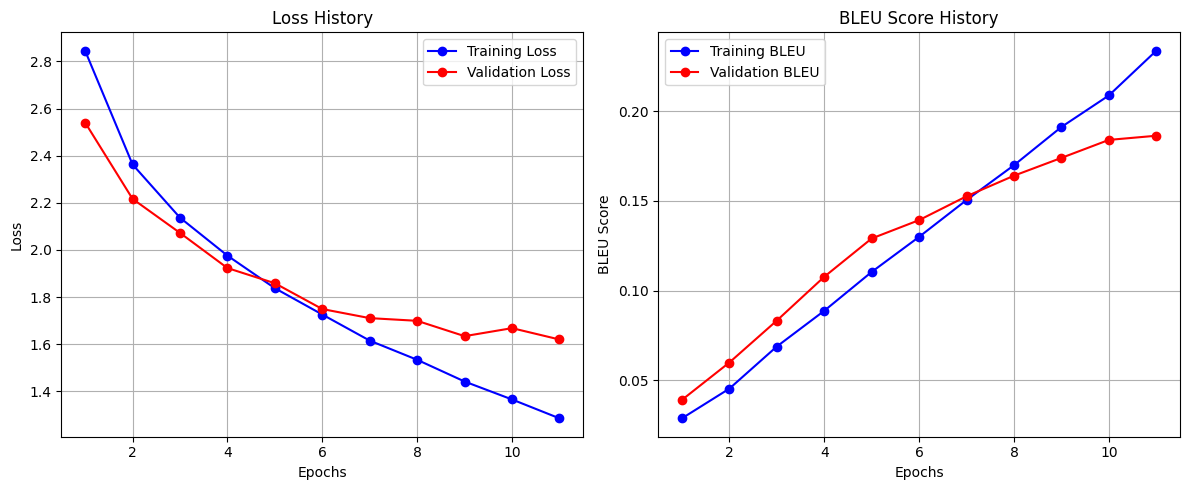

In [ ]:
import matplotlib.pyplot as plt
    # --- VẼ BIỂU ĐỒ ---

plt.figure(figsize=(12, 5))

    # Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, 'b-o', label='Training Loss')
plt.plot(epochs_range, val_loss_list, 'r-o', label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Đồ thị BLEU
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bleu_list, 'b-o', label='Training BLEU')
plt.plot(epochs_range, val_bleu_list, 'r-o', label='Validation BLEU')
plt.title('BLEU Score History')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Viết hàm dịch thuật EN - DE

In [ ]:
def translate(sentence: str):
    model.eval()

    # --- Encode sentence ---
    src_ids = Text2ListNum(sentence, en_tokenizer, vocab_src)
    src = torch.tensor([src_ids], dtype=torch.long)    # shape: [1, src_len]
    src = src.to(next(model.parameters()).device)

    with torch.no_grad():
        # input embedding
        embedded_src = model.encoder_embedding(src)     # [1, src_len, emb]

        # Encoder
        _, (h, c) = model.encoder_lstm(embedded_src)

        # Decode
        input_token = torch.tensor([SOS_IDX], device=src.device)
        decoded_ids = []

        for _ in range(50):  # max_len
            emb = model.decoder_embedding(input_token).unsqueeze(0)   # [1,1,emb]
            output, (h, c) = model.decoder_lstm(emb, (h, c))
            logits = model.fc(output.squeeze(0))                      # [1, vocab]
            next_token = logits.argmax(-1)                            # [1]

            token_id = next_token.item()
            decoded_ids.append(token_id)

            if token_id == EOS_IDX:
                break
            
            input_token = next_token # Lấy từ vừa dự đoán làm đầu vào cho vòng lặp sau

        # dùng lookup_tokens thay vì .decode()
        try:
            tokens = vocab_target.lookup_tokens(decoded_ids)
            return " ".join(tokens)
        except AttributeError:
            # Fallback cho phiên bản cũ
            itos = vocab_target.get_itos()
            return " ".join([itos[i] for i in decoded_ids])

        # # Convert IDs → words
        # return vocab_target.decode(decoded_ids)


In [ ]:
import random
# --- 1. HÀM ĐÁNH GIÁ TOÀN BỘ TẬP TEST ---
def evaluate_all_test(model, test_loader, device):
    print(f"\n{'='*10} ĐANG CHẠY ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP TEST {'='*10}")
    print(f"Tổng số batch cần xử lý: {len(test_loader)}")
    
    model.eval()
    total_bleu = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    
    with torch.no_grad():
        for i, (src, trg, src_len, trg_len) in enumerate(test_loader):
            src, trg = src.to(device), trg.to(device)

            # Chạy model với teacher_forcing = 0 (tự sinh từ hoàn toàn)
            output = model(src, trg, src_len, trg_len, teacher_forcing_ratio=0)

            # 1. Tính Loss
            output_dim = output.shape[-1]
            loss = criterion(output.view(-1, output_dim), trg.view(-1))
            total_loss += loss.item()

            # 2. Tính BLEU (dùng hàm compute_bleu đã sửa ở trên)
            bleu = compute_bleu(output, trg)
            total_bleu += bleu
            
            # In tiến độ (optional)
            if (i+1) % 10 == 0:
                print(f"-> Đã xong batch {i+1}/{len(test_loader)}")

    avg_loss = total_loss / len(test_loader)
    avg_bleu = total_bleu / len(test_loader)

    print(f"\n{'='*40}")
    print(f"KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average BLEU: {avg_bleu:.4f} (Thang 0-1)")
    print(f"Average BLEU: {avg_bleu*100:.2f} (Thang 100)")
    print(f"{'='*40}\n")
    return avg_bleu

# --- 2. HÀM HIỂN THỊ MẪU NGẪU NHIÊN ---
def show_random_samples(dataset, model, device, num_samples=20):
    print(f"{'='*10} CÁC MẪU DỊCH NGẪU NHIÊN ({num_samples} CÂU) {'='*10}")
    
    # Lấy index ngẫu nhiên
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        src_raw, trg_raw = dataset[idx]
        
        # Dùng hàm translate để dịch
        pred_trg = translate(src_raw)
        
        print(f"Mẫu #{idx}:")
        print(f"Input:     {src_raw.strip()}")
        print(f"Target:    {trg_raw.strip()}")
        print(f"Machine:   {pred_trg}")
        print("-" * 60)

In [ ]:
test_loader = DataLoader(test_datasets, batch_size=128, shuffle=False, collate_fn=collate_fn)

# 2. Tính điểm số tổng thể
final_score = evaluate_all_test(model, test_loader, device)

# 3. Xem các ví dụ cụ thể
show_random_samples(test_datasets, model, device, num_samples=5)


========== ĐANG CHẠY ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP TEST ==========
Tổng số batch cần xử lý: 9

KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST:
Average Loss: 5.0122
Average BLEU: 0.1082 (Thang 0-1)
Average BLEU: 10.82 (Thang 100)

========== CÁC MẪU DỊCH NGẪU NHIÊN (5 CÂU) ==========
Mẫu #131:
Input:     A woman on a bus with her chin in her hand with her eyes closed.
Target:    Frau im Bus, Kopf auf die Hand gestützt, mit geschlossenen Augen
Machine:   Eine Frau auf einem <unk> mit ihren Händen mit ihrer Händen . <eos>
------------------------------------------------------------
Mẫu #99:
Input:     A man walks dow a dirt path on the side of the road.
Target:    Ein Mann geht auf einem unbefestigten Weg neben der Straße.
Machine:   Ein Mann geht auf einem Feldweg entlang der Straße entlang . <eos>
------------------------------------------------------------
Mẫu #973:
Input:     Landscape with trees and at the end the sun shining
Target:    Landschaft mit Bäumen und ganz hinten scheint die Sonne.
Machine: